<a href="https://colab.research.google.com/github/Akshayalaxmi/CodeClauseInternship_RoadLaneDetection/blob/main/RoadLaneDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Road lane detetction for images

In [ ]:
import math
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)


In [ ]:
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

In [ ]:
def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

In [ ]:
def region_of_interest(img, vertices):
    mask = np.zeros_like(img)
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [ ]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

In [ ]:
def slope_lines(image,lines):

    img = image.copy()
    poly_vertices = []
    order = [0,1,3,2]

    left_lines = []
    right_lines = []
    for line in lines:
        for x1,y1,x2,y2 in line:

            if x1 == x2:
                pass
            else:
                m = (y2 - y1) / (x2 - x1)
                c = y1 - m * x1

                if m < 0:
                    left_lines.append((m,c))
                elif m >= 0:
                    right_lines.append((m,c))

    left_line = np.mean(left_lines, axis=0)
    right_line = np.mean(right_lines, axis=0)

    for slope, intercept in [left_line, right_line]:
        rows, cols = image.shape[:2]
        y1= int(rows)
        y2= int(rows*0.6)
        x1=int((y1-intercept)/slope)
        x2=int((y2-intercept)/slope)
        poly_vertices.append((x1, y1))
        poly_vertices.append((x2, y2))
        draw_lines(img, np.array([[[x1,y1,x2,y2]]]))

    poly_vertices = [poly_vertices[i] for i in order]
    cv2.fillPoly(img, pts = np.array([poly_vertices],'int32'), color = (230, 230, 250))
    return cv2.addWeighted(image,0.7,img,0.4,0.)

In [ ]:
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    line_img = slope_lines(line_img,lines)
    return line_img

In [ ]:
def weighted_img(img, initial_img, α=0.1, β=1., γ=0.):
    lines_edges = cv2.addWeighted(initial_img, α, img, β, γ)
    return lines_edges

In [ ]:
def get_vertices(image):
    rows, cols = image.shape[:2]
    bottom_left  = [cols*0.15, rows]
    top_left     = [cols*0.45, rows*0.6]
    bottom_right = [cols*0.95, rows]
    top_right    = [cols*0.55, rows*0.6]
    ver = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    return ver

In [ ]:
def lane_finding_pipeline(image):
    gray_img = grayscale(image)
    smoothed_img = gaussian_blur(img = gray_img, kernel_size = 5)
    canny_img = canny(img = smoothed_img, low_threshold = 50, high_threshold = 200)
    masked_img = region_of_interest(img = canny_img, vertices = get_vertices(image))
    houghed_lines = hough_lines(img = masked_img, rho = 1, theta = np.pi/180, threshold = 20, min_line_len = 20, max_line_gap = 180)
    output = weighted_img(img = houghed_lines, initial_img = image, α=0.8, β=1., γ=0.)

    return output

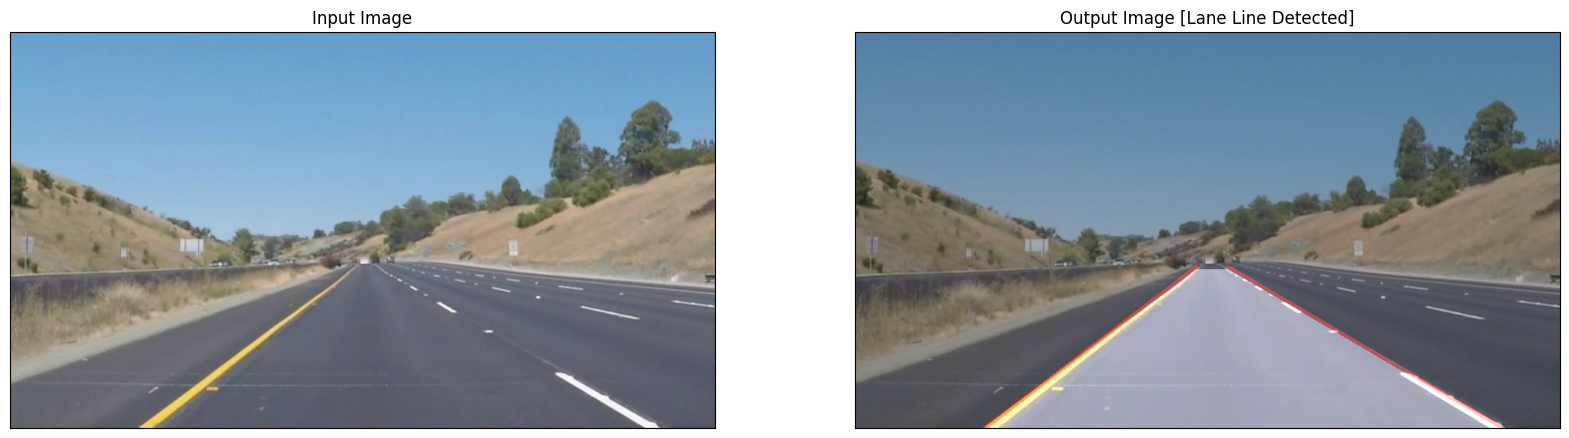

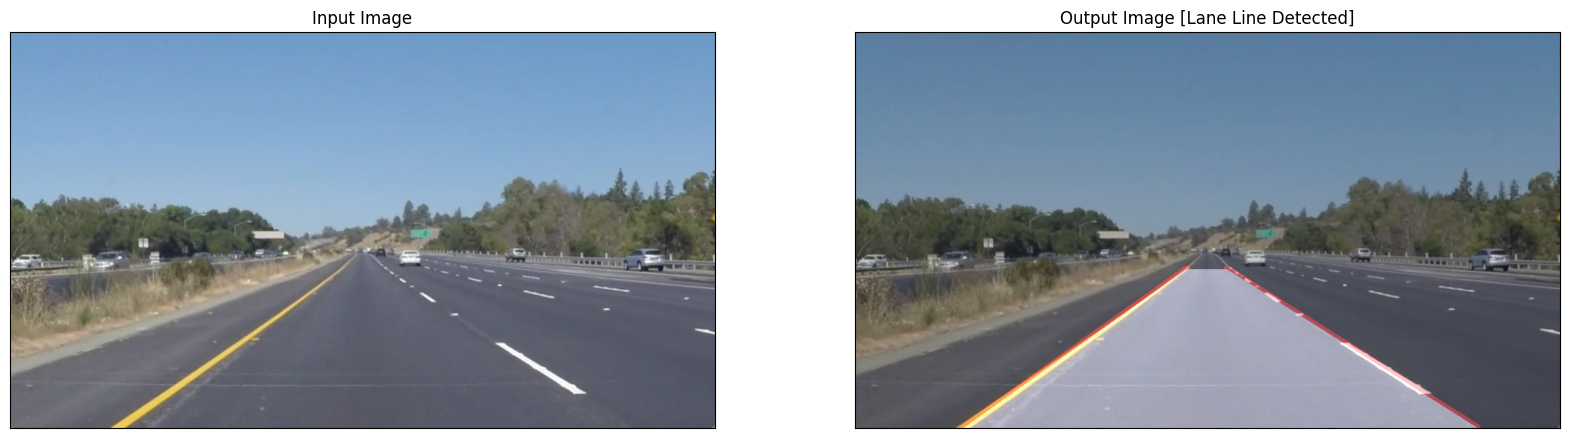

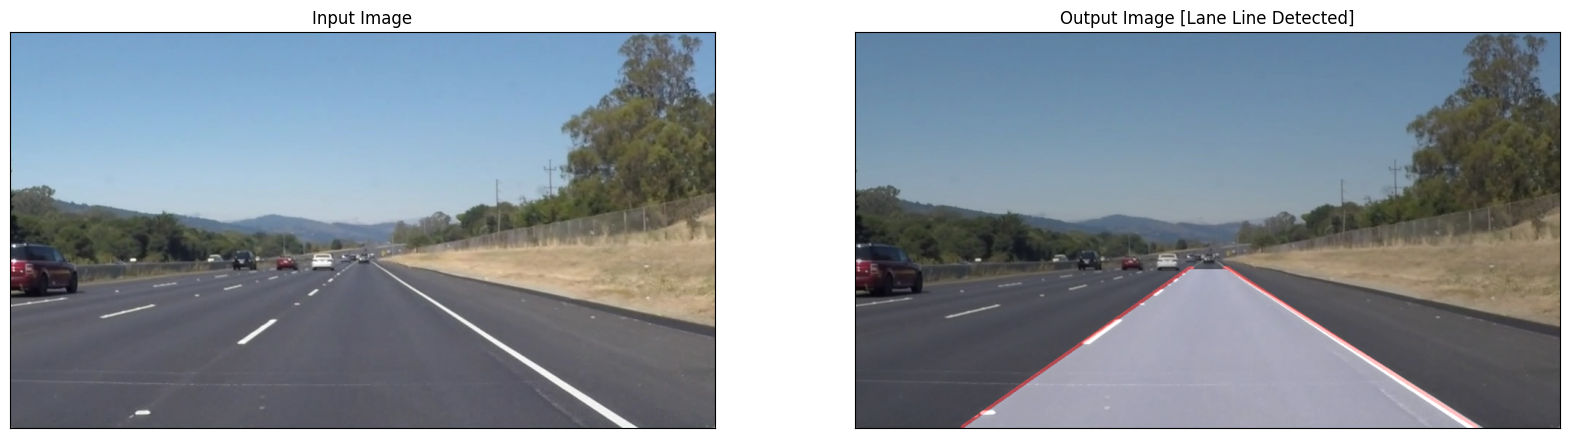

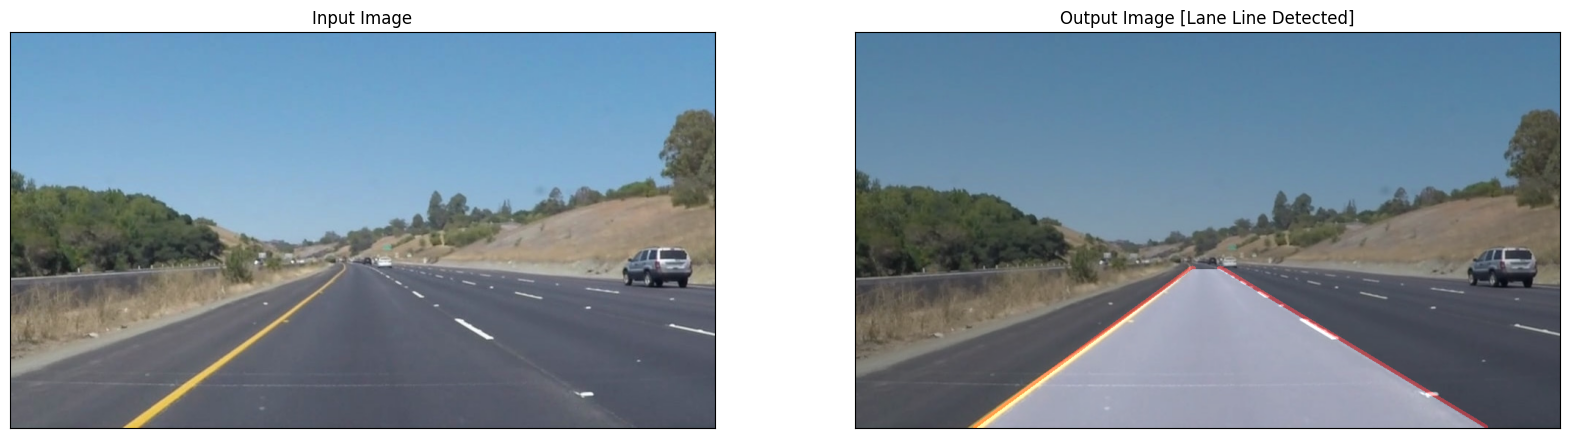

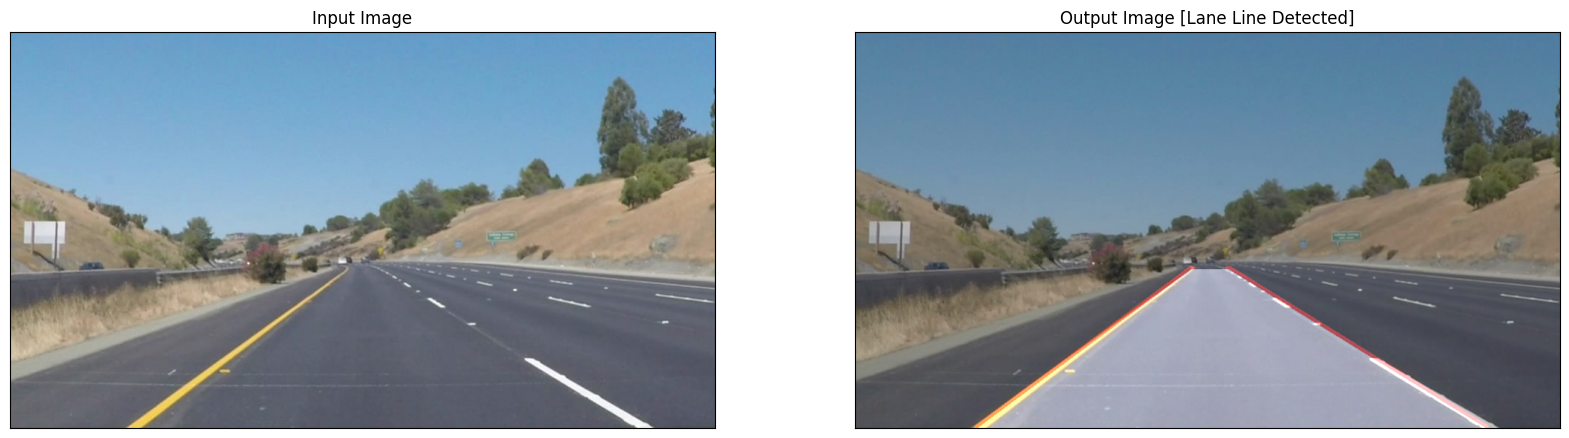

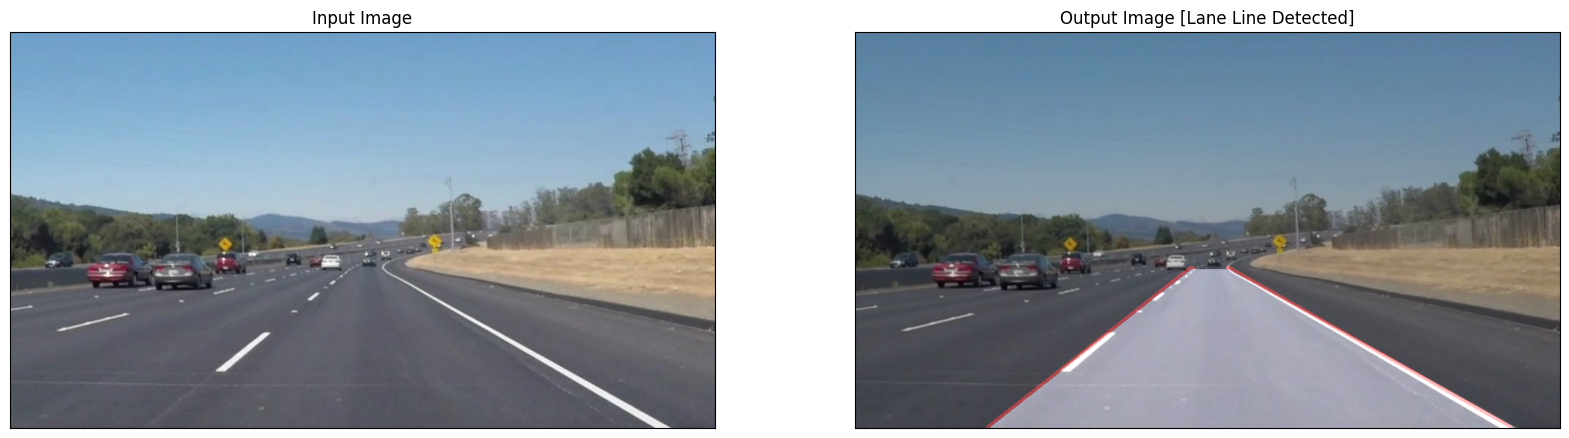

In [ ]:
import os

folder_path = '/content/roadlanedataset'
image_paths = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, filename))]
# print(image_paths)
for image_path in image_paths:
    if ".jpg" in image_path or ".png" in image_path:
      fig = plt.figure(figsize=(20, 10))
      image = mpimg.imread(image_path)
      ax = fig.add_subplot(1, 2, 1,xticks=[], yticks=[])
      plt.imshow(image)
      ax.set_title("Input Image")
      ax = fig.add_subplot(1, 2, 2,xticks=[], yticks=[])
      plt.imshow(lane_finding_pipeline(image))
      ax.set_title("Output Image [Lane Line Detected]")
      plt.show()

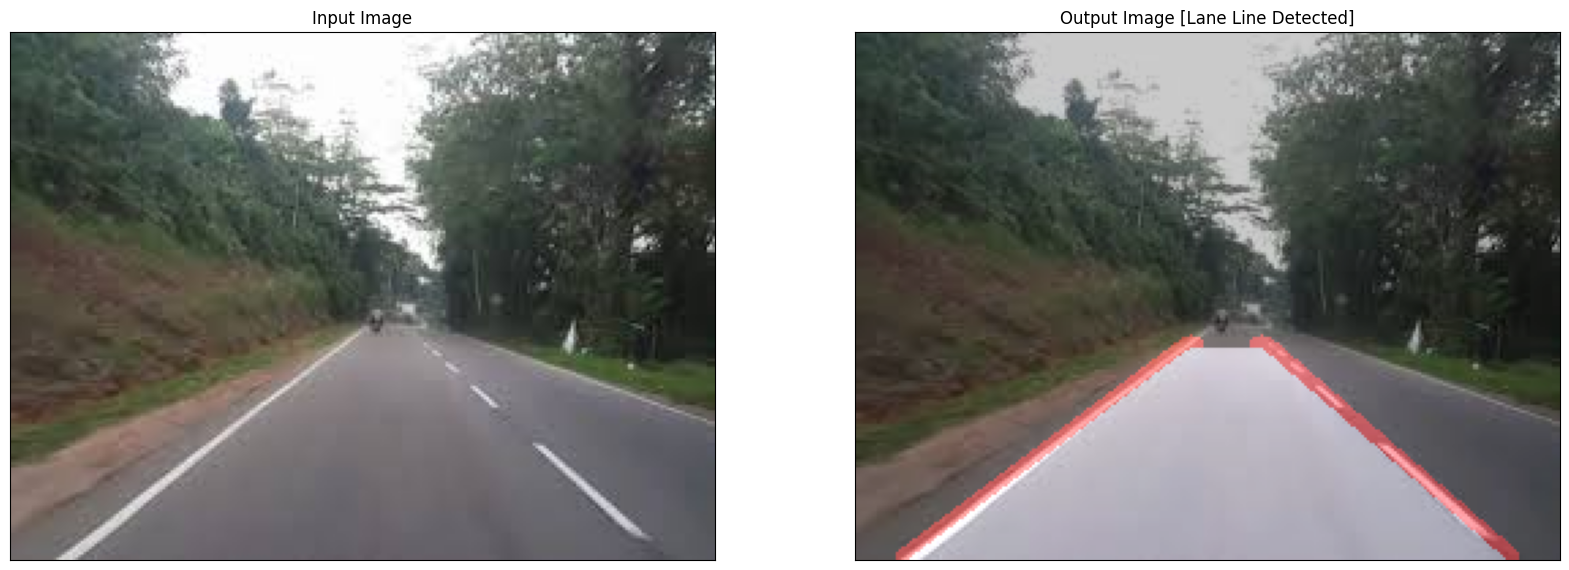

In [ ]:
fig = plt.figure(figsize=(20, 10))
image = mpimg.imread("/content/test_img.jpg")
ax = fig.add_subplot(1, 2, 1,xticks=[], yticks=[])
plt.imshow(image)
ax.set_title("Input Image")
ax = fig.add_subplot(1, 2, 2,xticks=[], yticks=[])
plt.imshow(lane_finding_pipeline(image))
ax.set_title("Output Image [Lane Line Detected]")
plt.show()

Road lane detetction for Videos

In [ ]:
from moviepy.editor import VideoFileClip

In [ ]:
white_output = 'output_1.mp4'
clip1 = VideoFileClip("/content/roadlanedataset/solidWhiteRight (2).mp4")
white_clip = clip1.fl_image(lane_finding_pipeline)
white_clip.write_videofile(white_output, audio=False)

Moviepy - Building video output_1.mp4.
Moviepy - Writing video output_1.mp4



Moviepy - Done !
Moviepy - video ready output_1.mp4


In [ ]:
test_output = 'output_2.mp4'
clip1 = VideoFileClip("/content/roadlanedataset/solidYellowLeft.mp4").subclip(20,26)
# clip1 = VideoFileClip("/content/roadlanedataset/solidYellowLeft.mp4")
white_clip = clip1.fl_image(lane_finding_pipeline)
white_clip.write_videofile(test_output, audio=False)

Moviepy - Building video output_2.mp4.
Moviepy - Writing video output_2.mp4



Moviepy - Done !
Moviepy - video ready output_2.mp4
